# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import os 
import resampy
from IPython.display import Audio
# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Deep Learning
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, losses, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D,SpatialDropout1D,GlobalAveragePooling1D, Dropout, BatchNormalization, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional

# Audio Processing
import pyaudio
import joblib
import pickle

# Web Framework
import streamlit as st

print("All libraries imported successfully!")

2025-06-23 02:52:34.415903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 02:52:34.429498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 02:52:34.444342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 02:52:34.448568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 02:52:34.462746: I tensorflow/core/platform/cpu_feature_guar

All libraries imported successfully!


# Data Loading and Preprocessing


In [2]:
Ravdess = "/home/dell/Desktop/Vansh/speech_sentimental_analysis/data" 
file_emotion = []
file_path = []

    # Emotion mapping
emotion_dict = {
    '01': 'neutral',
    '02': 'calm', 
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
    }

    # Traverse through speech and song directories
for root, dirs, files in os.walk(Ravdess):
    for file_name in files:
        if file_name.endswith('.wav'):
            parts = file_name.split('-')
            if len(parts) >= 3:
                emotion_code = parts[2]
                file_emotion.append(emotion_code)
                file_path.append(os.path.join(root, file_name))
            else:
                print(f"Unexpected filename format: {file_name}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

df.Emotions.replace({
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}, inplace=True)

# Preview the final dataframe
df.head()



,Emotions,Path
0,sad,/home/dell/Desktop/Vansh/speech_sentimental_an...
1,angry,/home/dell/Desktop/Vansh/speech_sentimental_an...
2,calm,/home/dell/Desktop/Vansh/speech_sentimental_an...
3,sad,/home/dell/Desktop/Vansh/speech_sentimental_an...
4,fear,/home/dell/Desktop/Vansh/speech_sentimental_an...


In [3]:
df.shape
df.to_csv("df.csv",index=False)

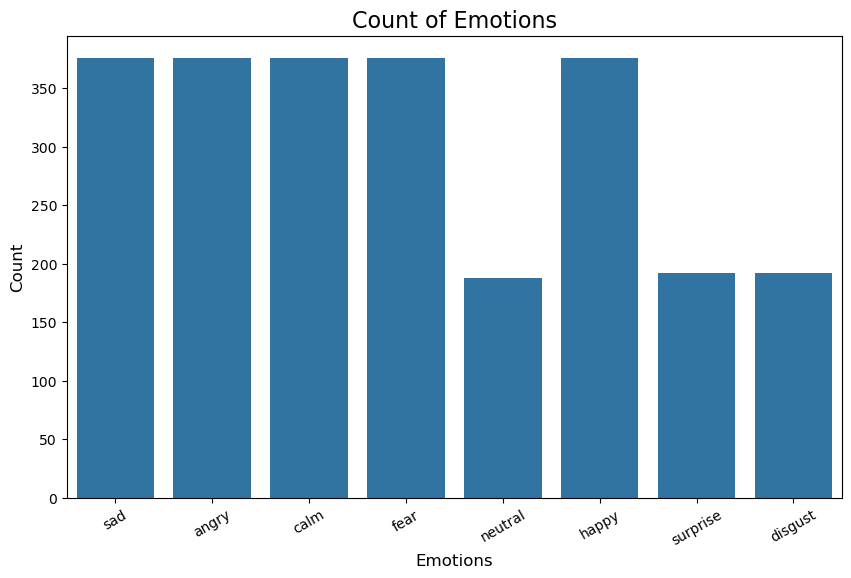

In [4]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=30)
plt.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()



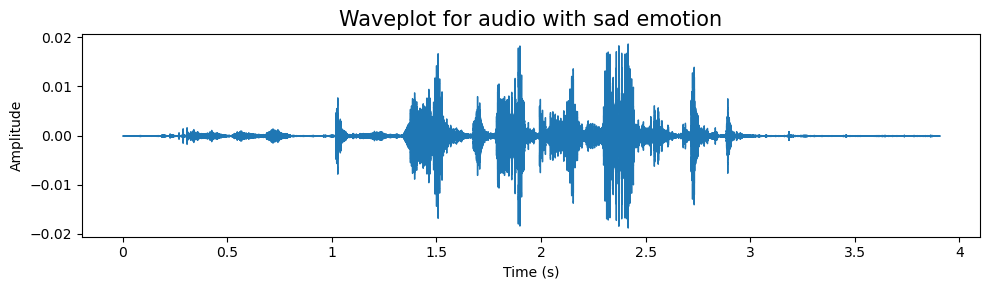

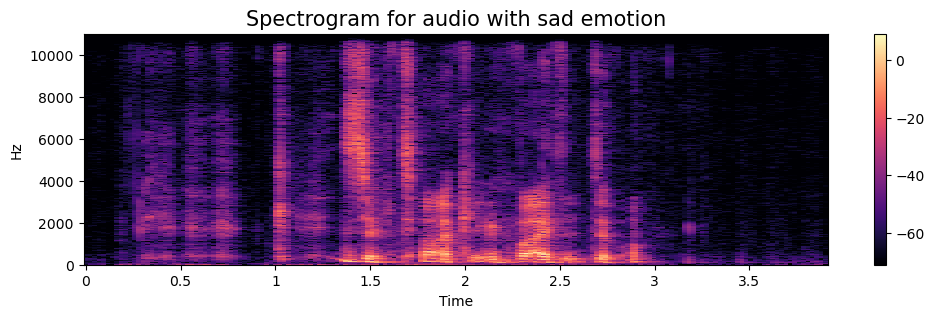

In [6]:
emotion='sad'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

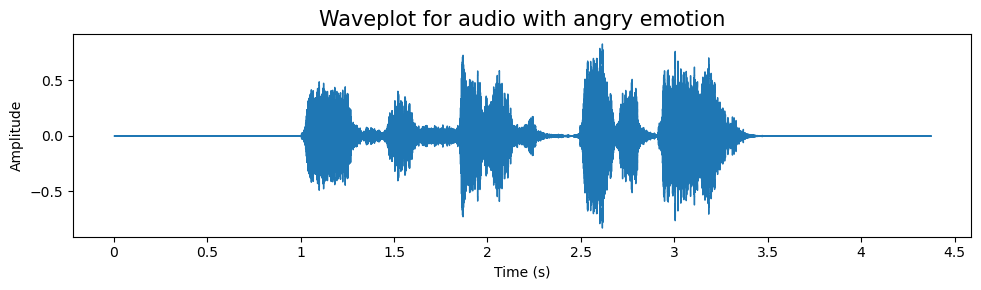

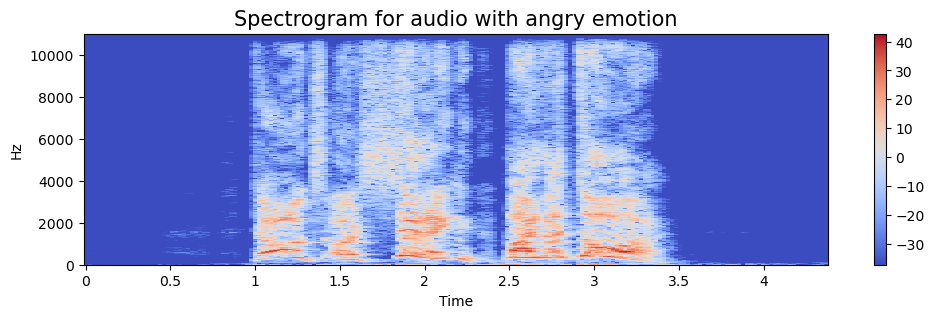

In [7]:
emotion='angry'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

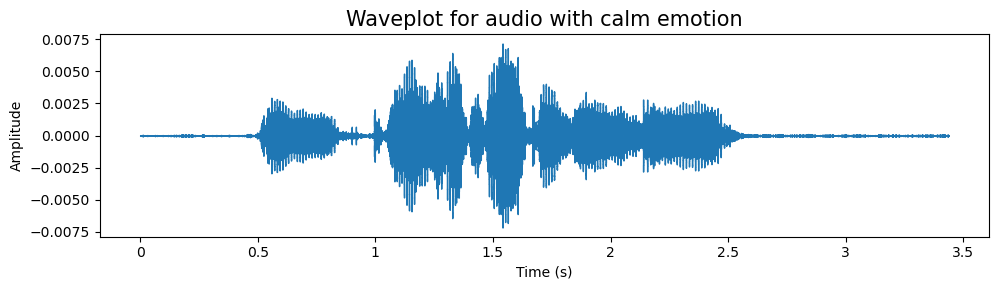

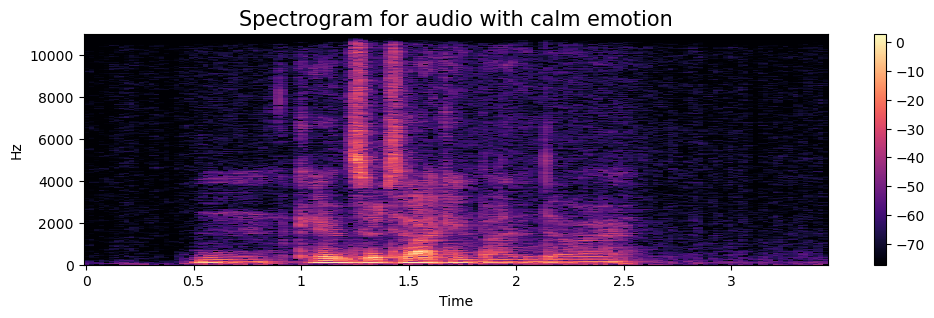

In [8]:
emotion='calm'
path = np.array(df.Path[df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


# taking any example and checking .
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

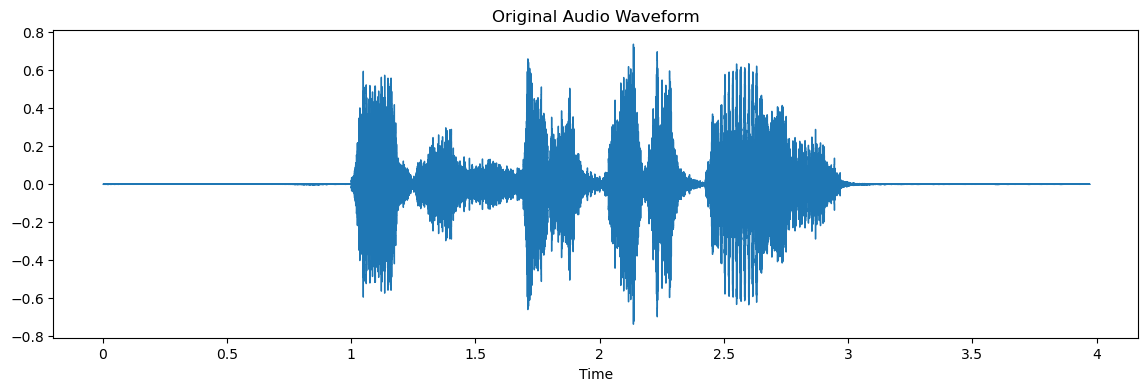

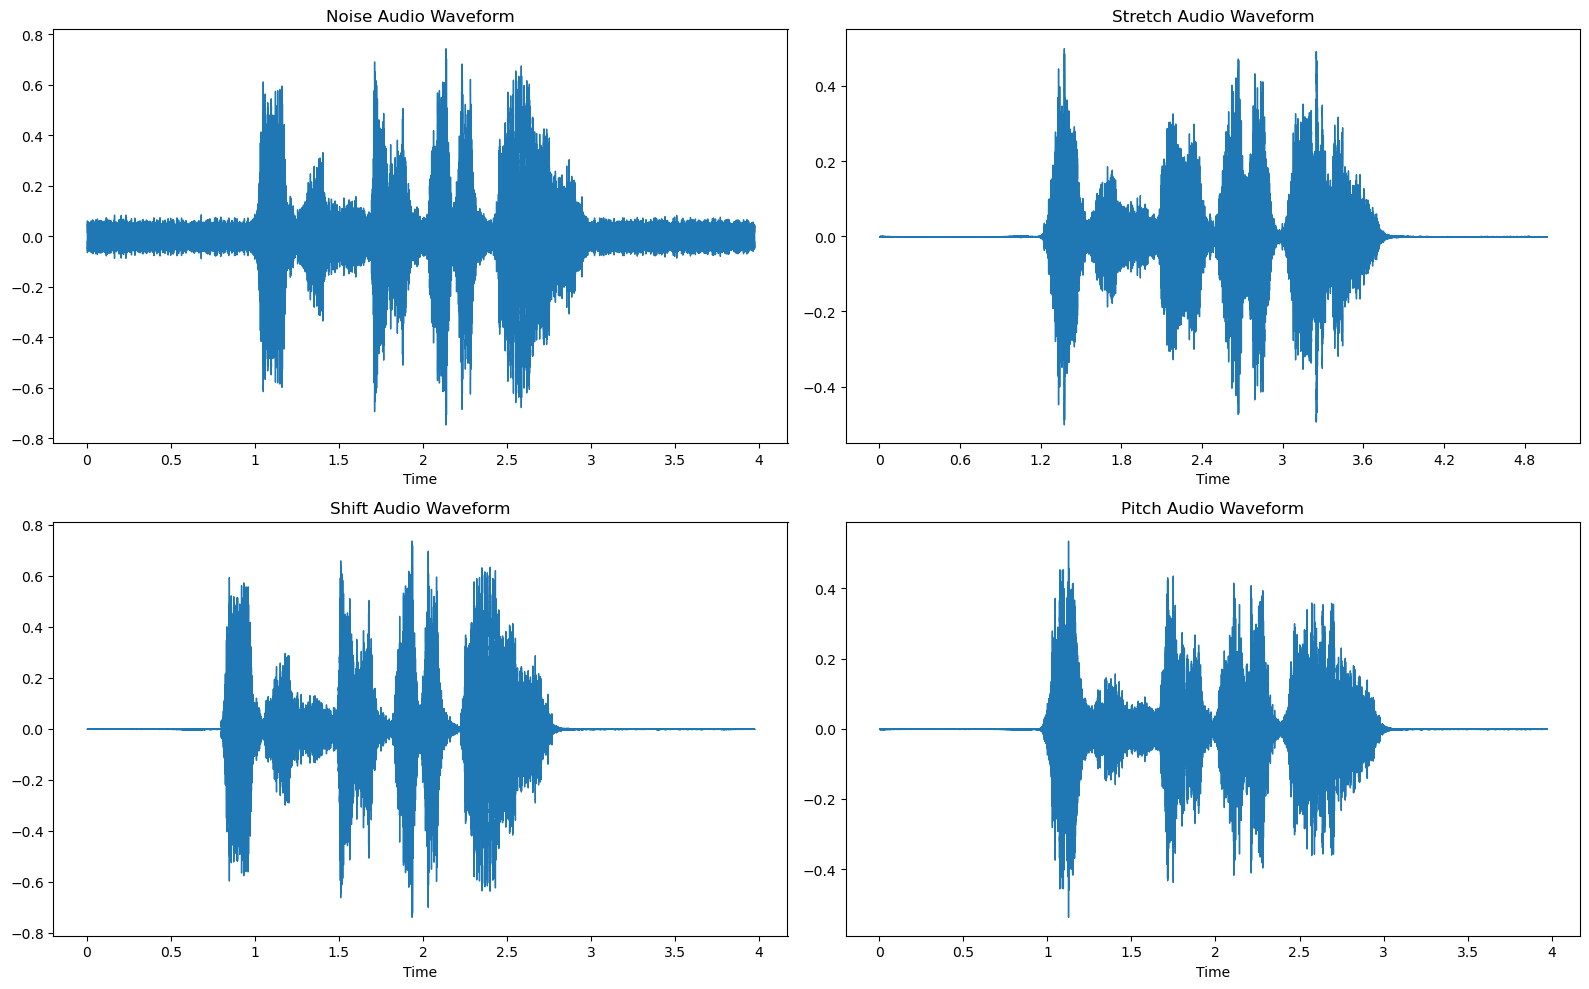

In [10]:
# Comparison with different transformations
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sampling_rate)
plt.title("Original Audio Waveform")
plt.show()

transformed = {
    "Noise": noise(data),
    "Stretch": stretch(data),
    "Shift": shift(data),
    "Pitch": pitch(data, sampling_rate)
}

# Plot transformed waveforms in subplots
plt.figure(figsize=(16, 10))

for i, (title, x) in enumerate(transformed.items(), 1):
    plt.subplot(2, 2, i)
    librosa.display.waveshow(y=x, sr=sampling_rate)
    plt.title(f"{title} Audio Waveform")

plt.tight_layout()
plt.show()


# Feature Extraction


In [11]:
def extract_features(data):
    result = []

    # Compute the Short-Time Fourier Transform magnitude
    stft_magnitude = np.abs(librosa.stft(data))
    
    # Chroma Short-Time Fourier Transform
    chroma = librosa.feature.chroma_stft(S=stft_magnitude, sr=sample_rate)
    chroma_mean = np.mean(chroma.T, axis=0)
    result.extend(chroma_mean)
    
    # Mel-frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    result.extend(mfccs_mean)

    # Zero Crossing Rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y=data)
    zcr_mean = np.mean(zcr.T, axis=0)
    result.extend(zcr_mean)

    # Mel-scaled spectrogram
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    mel_spec_mean = np.mean(mel_spec.T, axis=0)
    result.extend(mel_spec_mean)

    # Root Mean Square Energy
    rms = librosa.feature.rms(y=data)
    rms_mean = np.mean(rms.T, axis=0)
    result.extend(rms_mean)

    return np.array(result)

def get_features(path):
    # Load audio with fixed duration and slight offset to skip potential silence
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from original audio
    original_features = extract_features(data)
    all_features = np.array(original_features)

    # Apply noise augmentation and extract features
    noisy_audio = noise(data)
    noisy_features = extract_features(noisy_audio)
    all_features = np.vstack((all_features, noisy_features))

    # Apply time stretching followed by pitch shifting, then extract features
    stretched_audio = stretch(data)
    pitched_audio = pitch(stretched_audio, sample_rate)
    augmented_features = extract_features(pitched_audio)
    all_features = np.vstack((all_features, augmented_features))

    return all_features



In [12]:
from tqdm import tqdm

X, Y = [], []

# Iterate over each audio file and its associated emotion label
for file_path, label in tqdm(zip(df.Path, df.Emotions), total=len(df), desc="Extracting features"):
    features = get_features(file_path)  # Extract features for original + augmented versions
    
    # Append each extracted feature vector and corresponding label
    for vector in features:
        X.append(vector)
        Y.append(label)


Extracting features: 100%|██████████| 2452/2452 [03:16<00:00, 12.47it/s]


In [ ]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index=False)



In [148]:
features = pd.read_csv('features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.792049,0.779198,0.719248,0.755313,0.783892,0.740233,0.725688,0.774317,0.747310,0.736142,...,1.356556e-07,1.293188e-07,1.420294e-07,3.673362e-07,4.678286e-07,6.436446e-07,6.737217e-07,6.819840e-08,0.000461,sad
1,0.834960,0.836139,0.797767,0.814072,0.856462,0.766929,0.728288,0.750513,0.758884,0.759503,...,8.905841e-07,8.874777e-07,9.149118e-07,1.184422e-06,1.204540e-06,1.414743e-06,1.448062e-06,7.910493e-07,0.000503,sad
2,0.711796,0.729654,0.786326,0.730516,0.700842,0.724422,0.747961,0.716707,0.760572,0.783110,...,2.290765e-08,2.400361e-08,2.899598e-08,2.325096e-08,6.041324e-08,9.405276e-08,5.173682e-08,7.601403e-09,0.000207,sad
3,0.557015,0.607104,0.629997,0.698260,0.687888,0.614027,0.641028,0.597276,0.540665,0.499182,...,1.503081e-02,1.943611e-02,1.942739e-02,1.788608e-02,1.489622e-02,1.492599e-02,8.505082e-03,5.304305e-04,0.092392,angry
4,0.552518,0.611839,0.643261,0.690503,0.736393,0.688693,0.645264,0.636056,0.560384,0.524666,...,1.542449e-02,1.995097e-02,1.976900e-02,1.822280e-02,1.556610e-02,1.548670e-02,8.867536e-03,8.843429e-04,0.092715,angry


In [149]:
X = features.iloc[: ,:-1].values
y = features['labels'].values



In [150]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [151]:


x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True
)

# Check shapes
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)



(5884, 162) (5884, 8) (1472, 162) (1472, 8)


# Model 

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, cohen_kappa_score, accuracy_score
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


In [153]:
torch.cuda.empty_cache()

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [156]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()

        self.conv = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # changed from (1,3) to (1,2) for less aggressive pooling
            nn.Dropout(0.25),

            # Conv Block 3 (added)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.3),

            # Conv Block 4 (added)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((1, 1)),  # no downsampling here to keep shape consistent
            nn.Dropout(0.3)
        )

        # Now calculate LSTM input size:
        # Original: After conv layers, input size was 64 * 9 = 576
        # Now last conv layer outputs 256 channels and width shrunk by factor of 2 * 2 * 2 = 8 approx
        # Assuming input width ~ 24 (since 3 in permute dimension was from original shape),
        # so width after 3 pooling (stride 2 each) approx 24/8 = 3, height stays same (9)
        # After permute: [B, width, channels * height] = [B, 3, 256*9 = 2304]
        self.lstm_input_size = 256 * 9  
        self.lstm_hidden = 128
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden,
            num_layers=2,        # deeper LSTM with 2 layers
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Linear(self.lstm_hidden * 2, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)                     # e.g. [B, 256, 9, 3]
        x = x.permute(0, 3, 1, 2)           # [B, 3, 256, 9]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, 3, 256*9=2304]
        lstm_out, _ = self.lstm(x)          # [B, 3, 256]
        out = lstm_out[:, -1, :]            # [B, 256]
        out = self.fc(out)                  # [B, num_classes]
        return F.log_softmax(out, dim=1)


In [157]:
# Data Preparation

# Assuming x_train, y_train, x_test, y_test are loaded and one-hot labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train_tensor = torch.tensor(x_train.reshape(-1, 1, 9, 18), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1, 9, 18), dtype=torch.float32)

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

le = LabelEncoder()
le.fit(y_train_tensor.numpy())
num_classes = len(le.classes_)

batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [158]:
# Training Setup

model = CNNLSTM(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6
)

train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []
best_acc = 0.0
epochs = 300

In [159]:

# Training Loop

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")

    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
        loop.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    correct, total, running_loss = 0, 0, 0
    loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Testing]")
    with torch.no_grad():
        for xb, yb in loop:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
            loop.set_postfix(loss=loss.item(), acc=correct/total)

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total
    scheduler.step(train_loss)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth")

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

Epoch 10/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 580.04it/s, acc=0.277, loss=1.91]


Epoch 10 - Train Loss: 1.8411, Acc: 0.2716 | Test Loss: 1.8297, Acc: 0.2772


Epoch 20/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 648.15it/s, acc=0.298, loss=1.71]


Epoch 20 - Train Loss: 1.7506, Acc: 0.3018 | Test Loss: 1.7574, Acc: 0.2976


Epoch 30/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 600.85it/s, acc=0.353, loss=1.62]


Epoch 30 - Train Loss: 1.6626, Acc: 0.3343 | Test Loss: 1.6291, Acc: 0.3533


Epoch 40/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 659.95it/s, acc=0.409, loss=1.43]


Epoch 40 - Train Loss: 1.5530, Acc: 0.3912 | Test Loss: 1.5168, Acc: 0.4090


Epoch 50/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 601.97it/s, acc=0.467, loss=1.21]


Epoch 50 - Train Loss: 1.4582, Acc: 0.4463 | Test Loss: 1.4095, Acc: 0.4674


Epoch 60/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 641.18it/s, acc=0.511, loss=1.09]


Epoch 60 - Train Loss: 1.3495, Acc: 0.4976 | Test Loss: 1.3126, Acc: 0.5109


Epoch 70/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 571.62it/s, acc=0.567, loss=0.908]


Epoch 70 - Train Loss: 1.2642, Acc: 0.5335 | Test Loss: 1.1520, Acc: 0.5666


Epoch 80/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 566.45it/s, acc=0.577, loss=0.881]


Epoch 80 - Train Loss: 1.2049, Acc: 0.5597 | Test Loss: 1.1261, Acc: 0.5774


Epoch 90/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 531.50it/s, acc=0.63, loss=0.884]


Epoch 90 - Train Loss: 1.1237, Acc: 0.5862 | Test Loss: 1.0176, Acc: 0.6298


Epoch 100/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 585.51it/s, acc=0.671, loss=0.86]


Epoch 100 - Train Loss: 1.0559, Acc: 0.6178 | Test Loss: 0.9414, Acc: 0.6705


Epoch 110/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 592.46it/s, acc=0.645, loss=0.932]


Epoch 110 - Train Loss: 0.9530, Acc: 0.6582 | Test Loss: 1.0047, Acc: 0.6454


Epoch 120/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 602.21it/s, acc=0.675, loss=0.785]


Epoch 120 - Train Loss: 0.9075, Acc: 0.6798 | Test Loss: 0.8772, Acc: 0.6753


Epoch 130/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 590.51it/s, acc=0.612, loss=0.984]


Epoch 130 - Train Loss: 0.8443, Acc: 0.6970 | Test Loss: 1.0679, Acc: 0.6121


Epoch 140/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 607.90it/s, acc=0.723, loss=0.532]


Epoch 140 - Train Loss: 0.8020, Acc: 0.7106 | Test Loss: 0.7834, Acc: 0.7228


Epoch 150/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 654.39it/s, acc=0.682, loss=0.843]


Epoch 150 - Train Loss: 0.7146, Acc: 0.7483 | Test Loss: 0.8764, Acc: 0.6821


Epoch 160/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 582.74it/s, acc=0.76, loss=0.45]


Epoch 160 - Train Loss: 0.6866, Acc: 0.7592 | Test Loss: 0.7140, Acc: 0.7602


Epoch 170/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 665.10it/s, acc=0.751, loss=0.523]


Epoch 170 - Train Loss: 0.6350, Acc: 0.7797 | Test Loss: 0.7297, Acc: 0.7514


Epoch 180/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 601.03it/s, acc=0.75, loss=0.545]


Epoch 180 - Train Loss: 0.5972, Acc: 0.7933 | Test Loss: 0.7468, Acc: 0.7500


Epoch 190/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 577.61it/s, acc=0.662, loss=0.868]


Epoch 190 - Train Loss: 0.5864, Acc: 0.8010 | Test Loss: 0.9554, Acc: 0.6624


Epoch 200/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 648.20it/s, acc=0.781, loss=0.335]


Epoch 200 - Train Loss: 0.5255, Acc: 0.8176 | Test Loss: 0.6827, Acc: 0.7806


Epoch 210/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 615.33it/s, acc=0.768, loss=0.583]


Epoch 210 - Train Loss: 0.5229, Acc: 0.8171 | Test Loss: 0.7036, Acc: 0.7677


Epoch 220/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 636.22it/s, acc=0.812, loss=0.503]


Epoch 220 - Train Loss: 0.3968, Acc: 0.8611 | Test Loss: 0.5828, Acc: 0.8118


Epoch 230/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 646.32it/s, acc=0.805, loss=0.467]


Epoch 230 - Train Loss: 0.3486, Acc: 0.8839 | Test Loss: 0.5961, Acc: 0.8050


Epoch 240/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 593.76it/s, acc=0.802, loss=0.496]


Epoch 240 - Train Loss: 0.3564, Acc: 0.8831 | Test Loss: 0.6377, Acc: 0.8016


Epoch 250/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 566.98it/s, acc=0.811, loss=0.437]


Epoch 250 - Train Loss: 0.3394, Acc: 0.8868 | Test Loss: 0.6200, Acc: 0.8111


Epoch 260/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 632.14it/s, acc=0.676, loss=1.11]


Epoch 260 - Train Loss: 0.3057, Acc: 0.8982 | Test Loss: 0.9987, Acc: 0.6760


Epoch 270/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 635.32it/s, acc=0.817, loss=0.414]


Epoch 270 - Train Loss: 0.2975, Acc: 0.8985 | Test Loss: 0.5802, Acc: 0.8173


Epoch 280/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 550.77it/s, acc=0.821, loss=0.372]


Epoch 280 - Train Loss: 0.2949, Acc: 0.9026 | Test Loss: 0.5679, Acc: 0.8213


Epoch 290/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 591.27it/s, acc=0.821, loss=0.381]


Epoch 290 - Train Loss: 0.3129, Acc: 0.8992 | Test Loss: 0.5683, Acc: 0.8213


Epoch 300/300 [Testing]: 100%|██████████| 46/46 [00:00<00:00, 624.01it/s, acc=0.806, loss=0.421]

Epoch 300 - Train Loss: 0.2928, Acc: 0.8990 | Test Loss: 0.5931, Acc: 0.8057


In [161]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)



# Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       198
           1       0.89      0.92      0.90       248
           2       0.75      0.74      0.74       116
           3       0.82      0.75      0.79       236
           4       0.78      0.89      0.83       208
           5       0.80      0.82      0.81       110
           6       0.82      0.77      0.79       218
           7       0.85      0.80      0.82       138

    accuracy                           0.83      1472
   macro avg       0.82      0.82      0.82      1472
weighted avg       0.83      0.83      0.83      1472

Confusion Matrix:
[[172   1   3   6  12   1   1   2]
 [  2 227   2   2   2   7   4   2]
 [  7   1  86   5   7   2   3   5]
 [  7   7   4 178  16   0  20   4]
 [  4   5   2   4 185   3   1   4]
 [  1   4   1   3   1  90   9   1]
 [  2  10   8  15   7   6 168   2]
 [  4   1   9   4   7   3   0 110]]
Accuracy: 0.8261


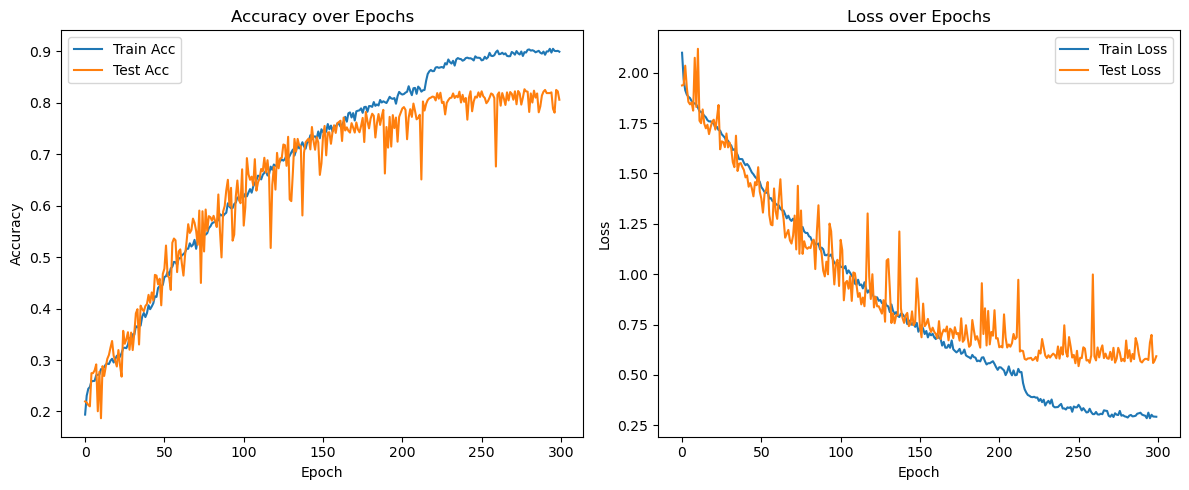

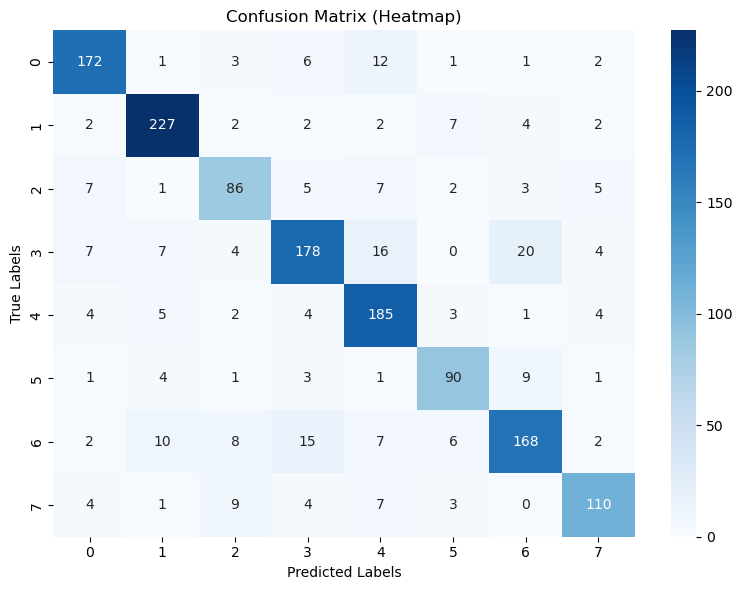

In [162]:

# Final Evaluation

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in le.classes_]))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# Visualization

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(test_acc_list, label='Test Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Heatmap)')
plt.tight_layout()
plt.show()